# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [4]:
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
rewards = []
for _ in range(100):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[-0.20010823 -1.02744332  0.23295734  1.6718122 ] 1 1.0 True {}
state, action, reward, done, info
[ 0.17378159  1.35675056 -0.24364532 -2.2456834 ] 1 1.0 True {}
state, action, reward, done, info
[-0.16011509 -0.41971558  0.21389347  0.91363833] 1 1.0 True {}
state, action, reward, done, info
[-0.14895972 -1.21229627  0.25341707  1.99010053] 1 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [19]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [20]:
def generator(states, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [21]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    outputs = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(outputs, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return outputs, Qs, loss

In [22]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.outputs, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [23]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [25]:
tf.reset_default_graph()
model = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                targetQ = sess.run(model.outputs, feed_dict)
                action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_targetQs = sess.run(model.outputs, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_targetQs[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_targetQs, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 19.0 Training loss: 1.1258 Explore P: 0.9981
Episode: 1 Total reward: 15.0 Training loss: 1.4938 Explore P: 0.9966
Episode: 2 Total reward: 14.0 Training loss: 1.7791 Explore P: 0.9953
Episode: 3 Total reward: 31.0 Training loss: 2.8558 Explore P: 0.9922
Episode: 4 Total reward: 56.0 Training loss: 41.0583 Explore P: 0.9867
Episode: 5 Total reward: 15.0 Training loss: 26.1326 Explore P: 0.9853
Episode: 6 Total reward: 41.0 Training loss: 169.0632 Explore P: 0.9813
Episode: 7 Total reward: 29.0 Training loss: 2604.2988 Explore P: 0.9785
Episode: 8 Total reward: 15.0 Training loss: 1599.8303 Explore P: 0.9770
Episode: 9 Total reward: 13.0 Training loss: 2006.0022 Explore P: 0.9757
Episode: 10 Total reward: 20.0 Training loss: 3379.4954 Explore P: 0.9738
Episode: 11 Total reward: 11.0 Training loss: 800.6068 Explore P: 0.9728
Episode: 12 Total reward: 9.0 Training loss: 948.0252 Explore P: 0.9719
Episode: 13 Total reward: 14.0 Training loss: 337.4760 Explore P: 0.

Episode: 113 Total reward: 20.0 Training loss: 20.3594 Explore P: 0.7159
Episode: 114 Total reward: 30.0 Training loss: 26.1220 Explore P: 0.7138
Episode: 115 Total reward: 18.0 Training loss: 32.6344 Explore P: 0.7125
Episode: 116 Total reward: 68.0 Training loss: 15.5386 Explore P: 0.7078
Episode: 117 Total reward: 45.0 Training loss: 197.1240 Explore P: 0.7046
Episode: 118 Total reward: 91.0 Training loss: 890.4016 Explore P: 0.6984
Episode: 119 Total reward: 72.0 Training loss: 158.3852 Explore P: 0.6934
Episode: 120 Total reward: 142.0 Training loss: 681.5903 Explore P: 0.6838
Episode: 121 Total reward: 112.0 Training loss: 27.0543 Explore P: 0.6763
Episode: 122 Total reward: 26.0 Training loss: 871.9083 Explore P: 0.6745
Episode: 123 Total reward: 39.0 Training loss: 413.9528 Explore P: 0.6720
Episode: 124 Total reward: 54.0 Training loss: 18.7674 Explore P: 0.6684
Episode: 125 Total reward: 43.0 Training loss: 40.7813 Explore P: 0.6656
Episode: 126 Total reward: 53.0 Training lo

Episode: 229 Total reward: 252.0 Training loss: 1.4815 Explore P: 0.1134
Episode: 230 Total reward: 322.0 Training loss: 3.4020 Explore P: 0.1101
Episode: 231 Total reward: 345.0 Training loss: 1.4582 Explore P: 0.1067
Episode: 232 Total reward: 374.0 Training loss: 1.4642 Explore P: 0.1032
Episode: 233 Total reward: 301.0 Training loss: 2.1368 Explore P: 0.1004
Episode: 234 Total reward: 378.0 Training loss: 13.0814 Explore P: 0.0971
Episode: 236 Total reward: 85.0 Training loss: 1.5755 Explore P: 0.0929
Episode: 237 Total reward: 326.0 Training loss: 1.4678 Explore P: 0.0903
Episode: 238 Total reward: 341.0 Training loss: 2.6567 Explore P: 0.0876
Episode: 240 Total reward: 77.0 Training loss: 6.9939 Explore P: 0.0840
Episode: 242 Total reward: 34.0 Training loss: 0.7721 Explore P: 0.0808
Episode: 243 Total reward: 308.0 Training loss: 2.3174 Explore P: 0.0787
Episode: 244 Total reward: 356.0 Training loss: 1.0268 Explore P: 0.0763
Episode: 245 Total reward: 297.0 Training loss: 4.110

Episode: 350 Total reward: 279.0 Training loss: 91.2442 Explore P: 0.0391
Episode: 351 Total reward: 260.0 Training loss: 8.1181 Explore P: 0.0383
Episode: 352 Total reward: 336.0 Training loss: 5.8479 Explore P: 0.0374
Episode: 354 Total reward: 99.0 Training loss: 71.3219 Explore P: 0.0361
Episode: 356 Total reward: 77.0 Training loss: 166.6281 Explore P: 0.0349
Episode: 357 Total reward: 307.0 Training loss: 12.3160 Explore P: 0.0341
Episode: 359 Total reward: 87.0 Training loss: 10.2236 Explore P: 0.0330
Episode: 360 Total reward: 354.0 Training loss: 60.9460 Explore P: 0.0322
Episode: 362 Total reward: 99.0 Training loss: 4.9287 Explore P: 0.0311
Episode: 364 Total reward: 18.0 Training loss: 20.6960 Explore P: 0.0302
Episode: 365 Total reward: 263.0 Training loss: 13.9004 Explore P: 0.0297
Episode: 366 Total reward: 331.0 Training loss: 8.7064 Explore P: 0.0291
Episode: 367 Total reward: 253.0 Training loss: 60.6347 Explore P: 0.0286
Episode: 368 Total reward: 386.0 Training loss

Episode: 477 Total reward: 221.0 Training loss: 3.0008 Explore P: 0.0120
Episode: 478 Total reward: 133.0 Training loss: 7.9135 Explore P: 0.0120
Episode: 479 Total reward: 8.0 Training loss: 55.8409 Explore P: 0.0120
Episode: 480 Total reward: 10.0 Training loss: 28.6905 Explore P: 0.0120
Episode: 481 Total reward: 110.0 Training loss: 56.7647 Explore P: 0.0120
Episode: 482 Total reward: 9.0 Training loss: 71.2144 Explore P: 0.0120
Episode: 483 Total reward: 9.0 Training loss: 276.7974 Explore P: 0.0120
Episode: 485 Total reward: 99.0 Training loss: 11.6786 Explore P: 0.0119
Episode: 486 Total reward: 221.0 Training loss: 14.5143 Explore P: 0.0118
Episode: 487 Total reward: 164.0 Training loss: 11.1037 Explore P: 0.0118
Episode: 488 Total reward: 114.0 Training loss: 13.3204 Explore P: 0.0118
Episode: 489 Total reward: 112.0 Training loss: 25.7768 Explore P: 0.0118
Episode: 490 Total reward: 313.0 Training loss: 8.8900 Explore P: 0.0117
Episode: 491 Total reward: 209.0 Training loss: 

Episode: 601 Total reward: 99.0 Training loss: 7.7616 Explore P: 0.0103
Episode: 602 Total reward: 335.0 Training loss: 1.6159 Explore P: 0.0103
Episode: 603 Total reward: 358.0 Training loss: 8.5226 Explore P: 0.0102
Episode: 604 Total reward: 293.0 Training loss: 12.0672 Explore P: 0.0102
Episode: 605 Total reward: 31.0 Training loss: 75.3499 Explore P: 0.0102
Episode: 606 Total reward: 11.0 Training loss: 162.6084 Explore P: 0.0102
Episode: 607 Total reward: 10.0 Training loss: 207.0013 Explore P: 0.0102
Episode: 608 Total reward: 8.0 Training loss: 337.4318 Explore P: 0.0102
Episode: 609 Total reward: 9.0 Training loss: 463.7320 Explore P: 0.0102
Episode: 610 Total reward: 9.0 Training loss: 586.4884 Explore P: 0.0102
Episode: 611 Total reward: 10.0 Training loss: 1199.7213 Explore P: 0.0102
Episode: 612 Total reward: 12.0 Training loss: 1756.5559 Explore P: 0.0102
Episode: 613 Total reward: 7.0 Training loss: 3818.8130 Explore P: 0.0102
Episode: 614 Total reward: 9.0 Training loss

Episode: 711 Total reward: 155.0 Training loss: 181.4583 Explore P: 0.0101
Episode: 712 Total reward: 131.0 Training loss: 163.6174 Explore P: 0.0101
Episode: 713 Total reward: 115.0 Training loss: 65.6623 Explore P: 0.0101
Episode: 714 Total reward: 131.0 Training loss: 83.3178 Explore P: 0.0101
Episode: 715 Total reward: 377.0 Training loss: 55.1865 Explore P: 0.0101
Episode: 716 Total reward: 239.0 Training loss: 35.8078 Explore P: 0.0101
Episode: 718 Total reward: 86.0 Training loss: 25.8707 Explore P: 0.0101
Episode: 719 Total reward: 338.0 Training loss: 43.6317 Explore P: 0.0101
Episode: 720 Total reward: 212.0 Training loss: 67.9491 Explore P: 0.0101
Episode: 721 Total reward: 119.0 Training loss: 722.5195 Explore P: 0.0101
Episode: 722 Total reward: 132.0 Training loss: 46.1713 Explore P: 0.0101
Episode: 723 Total reward: 238.0 Training loss: 88.9864 Explore P: 0.0101
Episode: 724 Total reward: 141.0 Training loss: 35.6173 Explore P: 0.0101
Episode: 725 Total reward: 397.0 Tra

Episode: 840 Total reward: 9.0 Training loss: 770.4969 Explore P: 0.0100
Episode: 841 Total reward: 12.0 Training loss: 1222.3118 Explore P: 0.0100
Episode: 842 Total reward: 9.0 Training loss: 1711.2478 Explore P: 0.0100
Episode: 843 Total reward: 12.0 Training loss: 1463.6586 Explore P: 0.0100
Episode: 844 Total reward: 9.0 Training loss: 2446.2395 Explore P: 0.0100
Episode: 845 Total reward: 8.0 Training loss: 2195.9863 Explore P: 0.0100
Episode: 846 Total reward: 12.0 Training loss: 324059.3125 Explore P: 0.0100
Episode: 847 Total reward: 10.0 Training loss: 1958.8132 Explore P: 0.0100
Episode: 848 Total reward: 9.0 Training loss: 1926.0195 Explore P: 0.0100
Episode: 850 Total reward: 74.0 Training loss: 120.0416 Explore P: 0.0100
Episode: 851 Total reward: 314.0 Training loss: 194.7624 Explore P: 0.0100
Episode: 852 Total reward: 340.0 Training loss: 86.7430 Explore P: 0.0100
Episode: 853 Total reward: 381.0 Training loss: 44.6383 Explore P: 0.0100
Episode: 854 Total reward: 144.0

Episode: 969 Total reward: 11.0 Training loss: 7010.3892 Explore P: 0.0100
Episode: 970 Total reward: 11.0 Training loss: 3314.9434 Explore P: 0.0100
Episode: 971 Total reward: 9.0 Training loss: 1875.8613 Explore P: 0.0100
Episode: 972 Total reward: 10.0 Training loss: 4083066.0000 Explore P: 0.0100
Episode: 973 Total reward: 8.0 Training loss: 5372.4849 Explore P: 0.0100
Episode: 974 Total reward: 9.0 Training loss: 5665.8193 Explore P: 0.0100
Episode: 975 Total reward: 10.0 Training loss: 5722.6201 Explore P: 0.0100
Episode: 976 Total reward: 10.0 Training loss: 7695.3252 Explore P: 0.0100
Episode: 977 Total reward: 7.0 Training loss: 4783.8262 Explore P: 0.0100
Episode: 978 Total reward: 11.0 Training loss: 8395.2539 Explore P: 0.0100
Episode: 979 Total reward: 13.0 Training loss: 5739.9478 Explore P: 0.0100
Episode: 980 Total reward: 115.0 Training loss: 5736.6748 Explore P: 0.0100
Episode: 981 Total reward: 9.0 Training loss: 7620.7632 Explore P: 0.0100
Episode: 982 Total reward:

Episode: 1083 Total reward: 225.0 Training loss: 32.4954 Explore P: 0.0100
Episode: 1084 Total reward: 105.0 Training loss: 20.2551 Explore P: 0.0100
Episode: 1085 Total reward: 158.0 Training loss: 17.2679 Explore P: 0.0100
Episode: 1086 Total reward: 117.0 Training loss: 16.8778 Explore P: 0.0100
Episode: 1087 Total reward: 11.0 Training loss: 52.2434 Explore P: 0.0100
Episode: 1088 Total reward: 12.0 Training loss: 151.2644 Explore P: 0.0100
Episode: 1089 Total reward: 11.0 Training loss: 27945.2695 Explore P: 0.0100
Episode: 1090 Total reward: 9.0 Training loss: 225.0145 Explore P: 0.0100
Episode: 1091 Total reward: 9.0 Training loss: 1463.0056 Explore P: 0.0100
Episode: 1092 Total reward: 8.0 Training loss: 1435.4952 Explore P: 0.0100
Episode: 1093 Total reward: 8.0 Training loss: 3279.6536 Explore P: 0.0100
Episode: 1094 Total reward: 12.0 Training loss: 24666.4863 Explore P: 0.0100
Episode: 1095 Total reward: 9.0 Training loss: 28171.6191 Explore P: 0.0100
Episode: 1096 Total re

Episode: 1192 Total reward: 235.0 Training loss: 230.7371 Explore P: 0.0100
Episode: 1193 Total reward: 96.0 Training loss: 69.9440 Explore P: 0.0100
Episode: 1194 Total reward: 71.0 Training loss: 269.3575 Explore P: 0.0100
Episode: 1195 Total reward: 89.0 Training loss: 433.7606 Explore P: 0.0100
Episode: 1196 Total reward: 58.0 Training loss: 512.5643 Explore P: 0.0100
Episode: 1197 Total reward: 64.0 Training loss: 137.3289 Explore P: 0.0100
Episode: 1198 Total reward: 143.0 Training loss: 84.7992 Explore P: 0.0100
Episode: 1199 Total reward: 93.0 Training loss: 68.6317 Explore P: 0.0100
Episode: 1200 Total reward: 116.0 Training loss: 16.4231 Explore P: 0.0100
Episode: 1201 Total reward: 70.0 Training loss: 3392.2026 Explore P: 0.0100
Episode: 1202 Total reward: 93.0 Training loss: 82.1304 Explore P: 0.0100
Episode: 1203 Total reward: 112.0 Training loss: 162.2253 Explore P: 0.0100
Episode: 1204 Total reward: 72.0 Training loss: 323.7383 Explore P: 0.0100
Episode: 1205 Total rewar

Episode: 1301 Total reward: 126.0 Training loss: 814.0758 Explore P: 0.0100
Episode: 1302 Total reward: 109.0 Training loss: 560.7938 Explore P: 0.0100
Episode: 1303 Total reward: 105.0 Training loss: 660.0375 Explore P: 0.0100
Episode: 1304 Total reward: 96.0 Training loss: 1171.2737 Explore P: 0.0100
Episode: 1305 Total reward: 92.0 Training loss: 377.9467 Explore P: 0.0100
Episode: 1306 Total reward: 93.0 Training loss: 6027.4365 Explore P: 0.0100
Episode: 1307 Total reward: 80.0 Training loss: 1225.9728 Explore P: 0.0100
Episode: 1308 Total reward: 100.0 Training loss: 1033.6145 Explore P: 0.0100
Episode: 1309 Total reward: 128.0 Training loss: 18926.8477 Explore P: 0.0100
Episode: 1310 Total reward: 87.0 Training loss: 900.7423 Explore P: 0.0100
Episode: 1311 Total reward: 95.0 Training loss: 547.2607 Explore P: 0.0100
Episode: 1312 Total reward: 97.0 Training loss: 572.4894 Explore P: 0.0100
Episode: 1313 Total reward: 108.0 Training loss: 370.0768 Explore P: 0.0100
Episode: 1314

Episode: 1414 Total reward: 7.0 Training loss: 7028761.0000 Explore P: 0.0100
Episode: 1415 Total reward: 12.0 Training loss: 55201.4922 Explore P: 0.0100
Episode: 1416 Total reward: 12.0 Training loss: 57648.5234 Explore P: 0.0100
Episode: 1417 Total reward: 10.0 Training loss: 100340.3984 Explore P: 0.0100
Episode: 1418 Total reward: 11.0 Training loss: 14904398.0000 Explore P: 0.0100
Episode: 1419 Total reward: 10.0 Training loss: 14138987.0000 Explore P: 0.0100
Episode: 1420 Total reward: 9.0 Training loss: 164361.0000 Explore P: 0.0100
Episode: 1421 Total reward: 12.0 Training loss: 101452.4531 Explore P: 0.0100
Episode: 1422 Total reward: 10.0 Training loss: 136170.1719 Explore P: 0.0100
Episode: 1423 Total reward: 8.0 Training loss: 150172.9531 Explore P: 0.0100
Episode: 1424 Total reward: 12.0 Training loss: 71561.2031 Explore P: 0.0100
Episode: 1425 Total reward: 10.0 Training loss: 101083.1172 Explore P: 0.0100
Episode: 1426 Total reward: 12.0 Training loss: 74656.7266 Explor

Episode: 1523 Total reward: 11.0 Training loss: 21529.0996 Explore P: 0.0100
Episode: 1524 Total reward: 10.0 Training loss: 23257.8066 Explore P: 0.0100
Episode: 1525 Total reward: 25.0 Training loss: 1420083.2500 Explore P: 0.0100
Episode: 1526 Total reward: 12.0 Training loss: 4078206.7500 Explore P: 0.0100
Episode: 1527 Total reward: 11.0 Training loss: 32434.4121 Explore P: 0.0100
Episode: 1528 Total reward: 10.0 Training loss: 17908.3750 Explore P: 0.0100
Episode: 1529 Total reward: 36.0 Training loss: 20283.2832 Explore P: 0.0100
Episode: 1530 Total reward: 9.0 Training loss: 44957.9648 Explore P: 0.0100
Episode: 1531 Total reward: 11.0 Training loss: 24323.4941 Explore P: 0.0100
Episode: 1532 Total reward: 9.0 Training loss: 1389520.8750 Explore P: 0.0100
Episode: 1533 Total reward: 59.0 Training loss: 23655.0410 Explore P: 0.0100
Episode: 1534 Total reward: 9.0 Training loss: 15803.5908 Explore P: 0.0100
Episode: 1535 Total reward: 11.0 Training loss: 21197.3828 Explore P: 0.0

Episode: 1631 Total reward: 81.0 Training loss: 92.9716 Explore P: 0.0100
Episode: 1632 Total reward: 73.0 Training loss: 61.5718 Explore P: 0.0100
Episode: 1633 Total reward: 74.0 Training loss: 78.0094 Explore P: 0.0100
Episode: 1634 Total reward: 60.0 Training loss: 82.3771 Explore P: 0.0100
Episode: 1635 Total reward: 71.0 Training loss: 55.6349 Explore P: 0.0100
Episode: 1636 Total reward: 85.0 Training loss: 302.4316 Explore P: 0.0100
Episode: 1637 Total reward: 70.0 Training loss: 83.4915 Explore P: 0.0100
Episode: 1638 Total reward: 77.0 Training loss: 240.4565 Explore P: 0.0100
Episode: 1639 Total reward: 101.0 Training loss: 61.7587 Explore P: 0.0100
Episode: 1640 Total reward: 89.0 Training loss: 111.6989 Explore P: 0.0100
Episode: 1641 Total reward: 125.0 Training loss: 165.8570 Explore P: 0.0100
Episode: 1642 Total reward: 177.0 Training loss: 40.9991 Explore P: 0.0100
Episode: 1643 Total reward: 119.0 Training loss: 56.9614 Explore P: 0.0100
Episode: 1644 Total reward: 95

Episode: 1741 Total reward: 93.0 Training loss: 66.0966 Explore P: 0.0100
Episode: 1742 Total reward: 128.0 Training loss: 65.1839 Explore P: 0.0100
Episode: 1743 Total reward: 152.0 Training loss: 23.0822 Explore P: 0.0100
Episode: 1744 Total reward: 101.0 Training loss: 37.6479 Explore P: 0.0100
Episode: 1745 Total reward: 116.0 Training loss: 46.4706 Explore P: 0.0100
Episode: 1746 Total reward: 91.0 Training loss: 86.8589 Explore P: 0.0100
Episode: 1747 Total reward: 163.0 Training loss: 35.9200 Explore P: 0.0100
Episode: 1748 Total reward: 68.0 Training loss: 85.9218 Explore P: 0.0100
Episode: 1749 Total reward: 64.0 Training loss: 42.7202 Explore P: 0.0100
Episode: 1750 Total reward: 138.0 Training loss: 42.0575 Explore P: 0.0100
Episode: 1751 Total reward: 117.0 Training loss: 69.2992 Explore P: 0.0100
Episode: 1752 Total reward: 104.0 Training loss: 128.7687 Explore P: 0.0100
Episode: 1753 Total reward: 185.0 Training loss: 38.8873 Explore P: 0.0100
Episode: 1754 Total reward: 

Episode: 1855 Total reward: 9.0 Training loss: 167.3844 Explore P: 0.0100
Episode: 1856 Total reward: 9.0 Training loss: 496.6073 Explore P: 0.0100
Episode: 1857 Total reward: 9.0 Training loss: 780.4336 Explore P: 0.0100
Episode: 1858 Total reward: 12.0 Training loss: 4180.1221 Explore P: 0.0100
Episode: 1859 Total reward: 9.0 Training loss: 922.8300 Explore P: 0.0100
Episode: 1860 Total reward: 12.0 Training loss: 459.8254 Explore P: 0.0100
Episode: 1861 Total reward: 140.0 Training loss: 94.0437 Explore P: 0.0100
Episode: 1863 Total reward: 3.0 Training loss: 1176.0481 Explore P: 0.0100
Episode: 1864 Total reward: 126.0 Training loss: 26.1641 Explore P: 0.0100
Episode: 1865 Total reward: 131.0 Training loss: 120.8186 Explore P: 0.0100
Episode: 1866 Total reward: 200.0 Training loss: 23.9206 Explore P: 0.0100
Episode: 1867 Total reward: 147.0 Training loss: 25.0381 Explore P: 0.0100
Episode: 1868 Total reward: 244.0 Training loss: 17.7345 Explore P: 0.0100
Episode: 1869 Total reward:

Episode: 1974 Total reward: 248.0 Training loss: 187.6069 Explore P: 0.0100
Episode: 1975 Total reward: 54.0 Training loss: 5443.7480 Explore P: 0.0100
Episode: 1976 Total reward: 151.0 Training loss: 1555.7556 Explore P: 0.0100
Episode: 1977 Total reward: 47.0 Training loss: 152.3546 Explore P: 0.0100
Episode: 1978 Total reward: 84.0 Training loss: 618.8173 Explore P: 0.0100
Episode: 1979 Total reward: 86.0 Training loss: 206.4129 Explore P: 0.0100
Episode: 1980 Total reward: 88.0 Training loss: 1127.8298 Explore P: 0.0100
Episode: 1981 Total reward: 93.0 Training loss: 244.9403 Explore P: 0.0100
Episode: 1982 Total reward: 78.0 Training loss: 220.1148 Explore P: 0.0100
Episode: 1983 Total reward: 113.0 Training loss: 61.8799 Explore P: 0.0100
Episode: 1984 Total reward: 111.0 Training loss: 50.7286 Explore P: 0.0100
Episode: 1985 Total reward: 337.0 Training loss: 26.1903 Explore P: 0.0100
Episode: 1986 Total reward: 235.0 Training loss: 28.3386 Explore P: 0.0100
Episode: 1987 Total 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

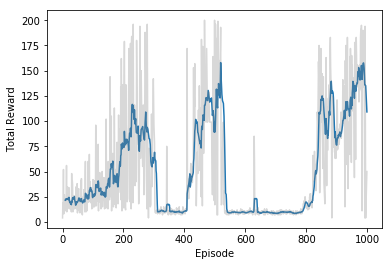

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed_dict = {mainQN.states: state.reshape((1, *state.shape))}
            targetQ = sess.run(mainQN.outputs, feed_dict)
            action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.